In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.integrate as spi
from IPython.display import Image
from matplotlib import rcParams
rcParams['lines.linewidth'] = 2
rcParams['font.size'] = 26
rcParams['legend.fontsize']= 'x-large'
rcParams['axes.titlesize']= 'x-large'
rcParams['xtick.labelsize']= 'x-large'
rcParams['ytick.labelsize']= 'x-large'
rcParams['axes.labelsize']= 'x-large'
rcParams['figure.titlesize']= 'xx-large'
rcParams['legend.title_fontsize']= 'xx-large'
%matplotlib inline
#rcParams.keys()

# Problema de Introducción.

Veamos un pequeño problema de modelamiento matemático como motivación a estudiar lo siguiente.

Este gráfico ilustra la evolución de la temperatura global en superficie con respecto a las temperaturas medias de 1951-1980. Diecinueve de los años más calurosos se han producido desde 2000, con la excepción de 1998. El año 2020 empató con 2016 como el año más caluroso registrado desde que se empezaron a llevar registros en 1880 (fuente: NASA/GISS). Esta investigación coincide en líneas generales con construcciones similares elaboradas por la Unidad de Investigación Climática y la Administración Nacional Oceánica y Atmosférica. La serie temporal que aparece a continuación muestra la variación media de cinco años de las temperaturas superficiales globales. El azul oscuro indica las zonas más frías que la media. El rojo oscuro indica las zonas más cálidas que la media.

La cifra de "Temperatura Global" en el tablero de la página principal muestra el cambio de la temperatura global desde 1880. Se obtiene esta cifra restando el primer punto de datos del gráfico del último punto de datos.

<img width="99%" src="../figures/global_temp_nasa_noaa.png"/> 

In [2]:
temp_data=pd.read_csv("../datas/global_temp_nasa_noaa.txt",delimiter="\s+",skiprows=2,header=0)
temp_data.head()

,Year,No_Smoothing,Lowess(5)
0,1880,-0.16,-0.09
1,1881,-0.08,-0.12
2,1882,-0.10,-0.16
3,1883,-0.17,-0.20
4,1884,-0.28,-0.23


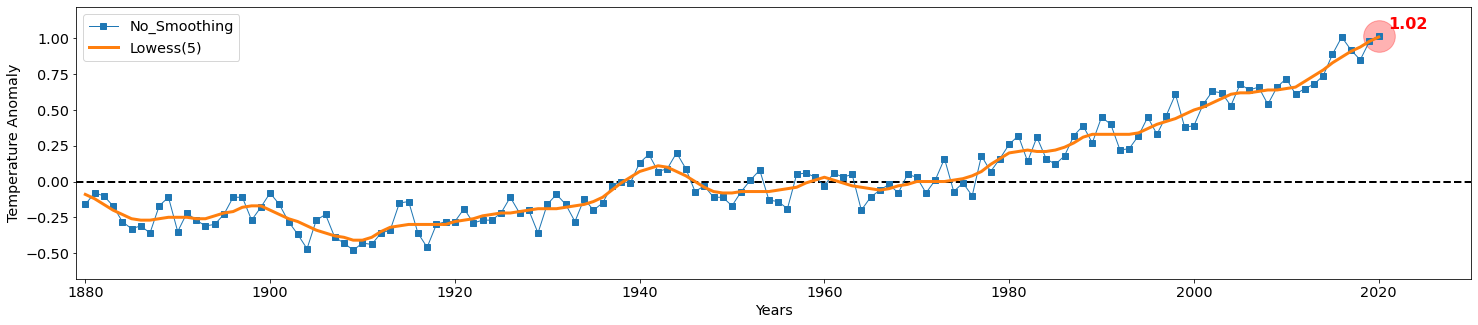

In [3]:
plt.figure(figsize=(25,5))
plt.plot(temp_data["Year"],temp_data["No_Smoothing"],marker="s",linewidth=1,label="No_Smoothing")
plt.plot(temp_data["Year"],temp_data["Lowess(5)"],linewidth=3,label="Lowess(5)")
plt.xlabel("Years")
plt.ylabel("Temperature Anomaly")
plt.text(temp_data["Year"].iloc[-1]+1,temp_data["No_Smoothing"].iloc[-1]+0.05,str(temp_data["No_Smoothing"].iloc[-1]),fontsize=16,color="red",weight="bold")
plt.axis([temp_data["Year"].min()-1,temp_data["Year"].max()+10,temp_data["No_Smoothing"].min()-0.2,temp_data["No_Smoothing"].max()+0.2])
plt.scatter(temp_data["Year"].iloc[-1],temp_data["No_Smoothing"].iloc[-1],s=1000,alpha=0.3,color="red")
plt.hlines(0,temp_data["Year"].min()-1,temp_data["Year"].max()+10,linestyles='--',color="k")
plt.legend()
plt.show()

### ¿Cómo podemos ver cuál será la razón de cambio de la anomalía de temperatura global de tal manera que podamos observar cuanto es la variación por año?

Esa es la pregunta que queremos responder y queremos resolver usando en este caso modelado en Python.

# Diferenciación Numérica en Python

## Enunciado del problema de diferenciación numérica

Una malla numérica es un conjunto de puntos espaciados uniformemente sobre el dominio de una función (es decir, la variable independiente), en algún intervalo. El espaciamiento o tamaño de paso de una cuadrícula numérica es la distancia entre puntos adyacentes en la cuadrícula. Si $x$ es una malla numérica, $x_j$ es el punto $j$ de la malla numérica y $h$ es el espaciado entre $x_{j-1}$ y $x_j$. La siguiente figura muestra un ejemplo de cuadrícula numérica.

<img width="40%" src="../figures/Numerical_grid.png">

Existen varias funciones en Python que pueden utilizarse para generar mallas numéricas. Para las rejillas numéricas en una dimensión, basta con utilizar la función linspace, que ya ha utilizado para crear matrices regularmente espaciadas.

En Python, una función $f(x)$ puede representarse en un intervalo calculando su valor en una cuadrícula. Aunque la función en sí puede ser continua, esta representación discreta o discretizada es útil para los cálculos numéricos y se corresponde con los conjuntos de datos que pueden adquirirse en la práctica de la ingeniería y la ciencia. En concreto, el valor de la función puede conocerse sólo en puntos discretos. Por ejemplo, un sensor de temperatura puede entregar pares de temperatura versus tiempo en intervalos de tiempo regulares. Aunque la temperatura es una función suave y continua del tiempo, el sensor sólo proporciona valores en intervalos de tiempo discretos, y en este caso particular, la función subyacente ni siquiera se conocería.

Tanto si $f$ es una función analítica o una representación discreta de una, nos gustaría derivar métodos de aproximación de la derivada de $f$ sobre una malla numérica y determinar su precisión.


## Derivadas de aproximación por diferencia finita

La derivada $f'(x)$ de una función $f(x)$ en el punto $x=a$ se define como:

\begin{equation}
f'(a)=\lim_{x\rightarrow a}\frac{f(x)-f(a)}{x-a}
\end{equation}

La derivada en $x=a$ es la pendiente en este punto. En las aproximaciones por diferencias finitas de esta pendiente, podemos utilizar valores de la función en la vecindad del punto $x=a$ para lograr el objetivo. Hay varias fórmulas de diferencias finitas utilizadas en diferentes aplicaciones, y a continuación se presentan tres de ellas, en las que la derivada se calcula utilizando los valores de dos puntos. 

La diferencia directa (o hacia delante) consiste en estimar la pendiente de la función en $x_j$ utilizando la línea que une $(x_j,f(x_j))$ y $(x_{j+1},f(x_{j+1}))$:

\begin{equation}
f'(x_j)=\frac{f(x_{j+1})-f(x_j)}{x_{j+1}-x_j}+\mathcal{O}(x_{j+1}-x_j)=\frac{f(x_{j+1})-f(x_j)}{h}++\mathcal{O}(h), \ \ \mbox{con}\ \  h=x_{j+1}-x_j.
\end{equation}

La diferencia hacia atrás consiste en estimar la pendiente de la función en $x_j$ utilizando la línea que une $(x_{j-1},f(x_{j-1}))$ y $(x_j,f(x_j))$:

\begin{equation}
f'(x_j)=\frac{f(x_j)-f(x_{j-1})}{x_j-x_{j-1}}+\mathcal{O}(x_j-x_{j-1})=\frac{f(x_j)-f(x_{j-1})}{h}+\mathcal{O}(h), \ \ \mbox{con $h$ también igual a}\ \  h=x_j-x_{j-1}.
\end{equation}

La diferencia central consiste en estimar la pendiente de la función en $x_j$ utilizando la línea que une $(x_{j-1},f(x_{j-1}))$ y $(x_{j+1},f(x_{j+1}))$:

\begin{equation}
f'(x_j)=\frac{f(x_{j+1})-f(x_{j-1})}{x_{j+1}-x_{j-1}}+\mathcal{O}(x_j-x_{j-1})=\frac{f(x_{j+1})-f(x_{j-1})}{2h}+\mathcal{O}(h), \ \ \mbox{con}\ \ 2h=x_{j+1}-x_{j-1}.
\end{equation}

La siguiente figura ilustra los tres tipos de fórmulas para estimar la pendiente.

<img width="80%" src="../figures/Finite-difference.png">

Esta fórmula es una mejor aproximación para la derivada en $x_j$ que la fórmula de la diferencia central, pero requiere el doble de cálculos.

\begin{equation}
f'(x_j)=\frac{f(x_{j-2})-8f(x_{j-1})+8f(x_{j+1})-f(x_{j+2})}{12h}+\mathcal{O}(h^4).
\end{equation}

**¡CONSEJO!** Python tiene un comando que puede utilizarse para calcular directamente las diferencias finitas: para un vector $f$, el comando `d=np.diff(f)`  produce una matriz $d$ en la que las entradas son las diferencias de los elementos adyacentes en la matriz inicial $f$. En otras palabras, $d(i)=f(i+1)-f(i)$.

**¡ATENCIÓN!** Cuando se utiliza el comando `np.diff`, el tamaño de la salida es uno menos que el tamaño de la entrada ya que necesita dos argumentos para producir una diferencia.

**EJEMPLO:** Consideremos la función $f(x)=cos(x)$. Sabemos que la derivada de $cos(x)$ es $-sin(x)$. Aunque en la práctica puede que no conozcamos la función subyacente para la que estamos encontrando la derivada, utilizamos el ejemplo simple para ilustrar los métodos de diferenciación numérica mencionados y su precisión. El siguiente código calcula las derivadas numéricamente.

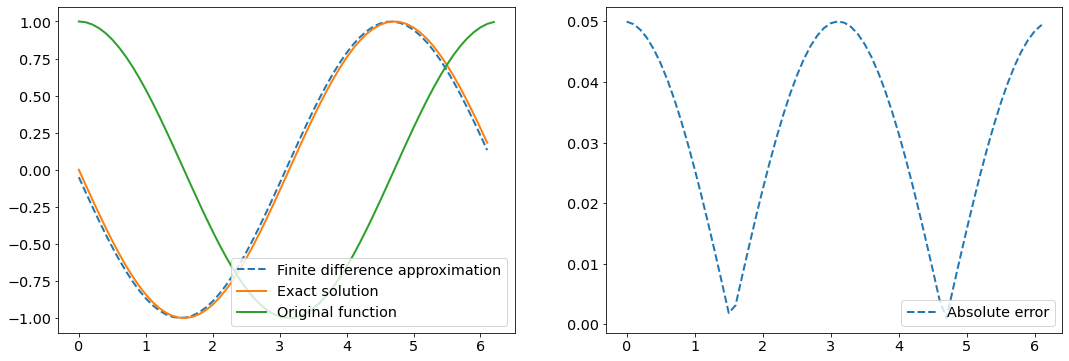

Error máximo es = 0.049984407218554114


In [5]:
# step size
h = 0.1
# define grid
x = np.arange(0, 2*np.pi, h) 
# compute function
y = np.cos(x) 

# compute vector of forward differences
forward_diff = np.diff(y)/h 
# compute corresponding grid
x_diff = x[:-1] 
# compute exact solution
exact_solution = -np.sin(x_diff) 

# Plot solution
plt.figure(figsize = (18, 6))
plt.subplot(121)
plt.plot(x_diff,forward_diff,'--',label='Finite difference approximation')
plt.plot(x_diff,exact_solution,label='Exact solution')
plt.plot(x,y,label='Original function')
plt.legend(loc=4)
plt.subplot(122)
plt.plot(x_diff, abs(forward_diff-exact_solution),'--',label='Absolute error')

plt.legend(loc=4)
plt.show()

# Compute max error between 
# numerical derivative and exact solution
max_error = max(abs(exact_solution - forward_diff))
print("Error máximo es =",max_error)

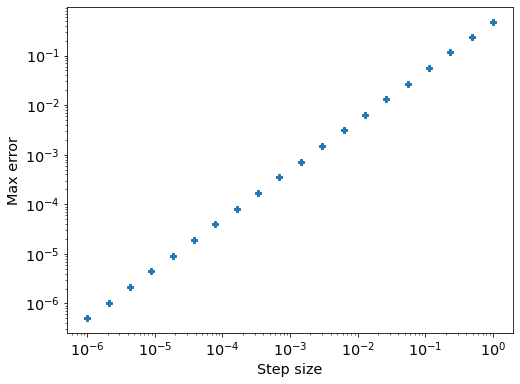

In [6]:
# En el ejemplo anterior hemos hecho pasos de tamaño h=0.1. Vamos a ver como serían los errores considerando diferentes tamaños de paso o sub intervalos.
# define step size
h=np.logspace(0,-6,20)
# list to store max error for each step size
max_error = [] 

for i in h:
    x = np.arange(0, 2 * np.pi, i) 
    # compute function value at grid
    y = np.cos(x) 
    # compute vector of forward differences
    forward_diff = np.diff(y)/i 
    # compute corresponding grid
    x_diff = x[:-1] 
    # compute exact solution
    exact_solution = -np.sin(x_diff) 
    
    # Compute max error between numerical derivative and exact solution
    max_error.append(max(abs(exact_solution - forward_diff)))

# produce log-log plot of max error versus step size
plt.figure(figsize = (8, 6))
plt.loglog(h, max_error,marker='P',linewidth=0)
plt.xlabel("Step size")
plt.ylabel("Max error")
plt.show()

## Varias maneras de hacerlo

### Implementación usando definición

In [7]:
def derivative_0(f,a,method='central',h=0.01):
    '''Compute the difference formula for f'(a) with step size h.

    Parameters
    ----------
    f : function
        Vectorized function of one variable
    a : number
        Compute derivative at x = a
    method : string
        Difference formula: 'forward', 'backward' or 'central'
    h : number
        Step size in difference formula

    Returns
    -------
    float
        Difference formula:
            central: f(a+h) - f(a-h))/2h
            forward: f(a+h) - f(a))/h
            backward: f(a) - f(a-h))/h            
    '''
    if method == 'central':
        return (f(a + h) - f(a - h))/(2*h)
    elif method == 'forward':
        return (f(a + h) - f(a))/h
    elif method == 'backward':
        return (f(a) - f(a - h))/h
    else:
        raise ValueError("Method must be 'central', 'forward' or 'backward'.")

In [8]:
x1=np.linspace(-5,5,100)
f1=lambda x: x**4-4*x**3-x**2+10*x

In [9]:
derivative_0(f1,2)

-9.999599999999731

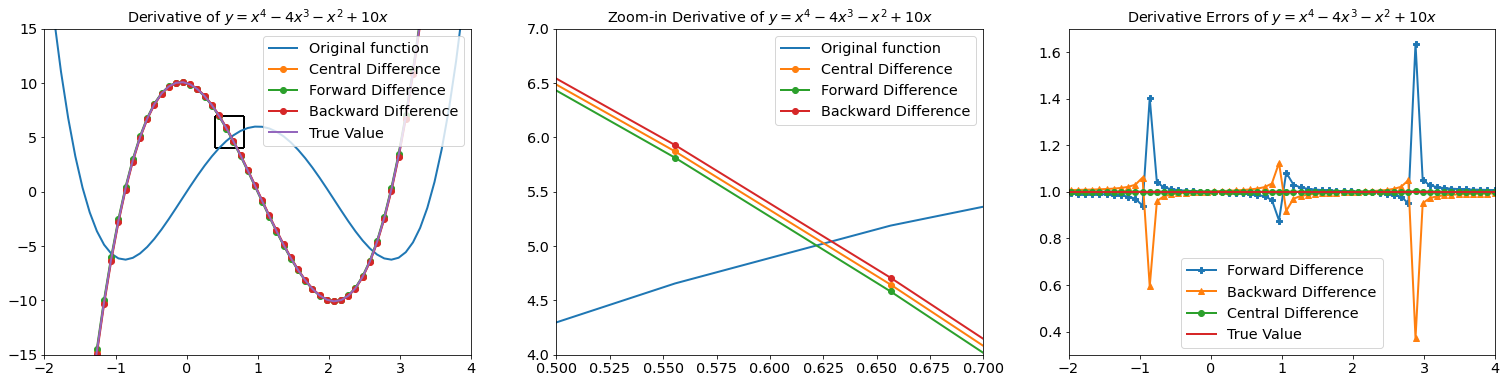

In [10]:
dydx = derivative_0(f1,x1)
dydx_b = derivative_0(f1,x1,method='backward')
dydx_f = derivative_0(f1,x1,method='forward')

dYdx = 4*x1**3-12*x1**2-2*x1+10

plt.figure(figsize=(26,6))
plt.subplot(131)
plt.plot(x1,f1(x1),label="Original function")
plt.plot(x1,dydx,'o-',label='Central Difference')
plt.plot(x1,dydx_f,'o-',label='Forward Difference')
plt.plot(x1,dydx_b,'o-',label='Backward Difference')
plt.plot(x1,dYdx,label='True Value')
plt.title('Derivative of $y = x^4-4x^3-x^2+10x$')
plt.legend(loc='best')
plt.hlines(4,0.4,0.8,linestyles='-',color='k')
plt.hlines(7,0.4,0.8,linestyles='-',color='k')
plt.vlines(0.4,4,7,linestyles='-',color='k')
plt.vlines(0.8,4,7,linestyles='-',color='k')
plt.ylim(-15,15)
plt.xlim(-2,4)
plt.subplot(132)
plt.plot(x1,f1(x1),label="Original function")
plt.plot(x1,dydx,'o-',label='Central Difference')
plt.plot(x1,dydx_f,'o-',label='Forward Difference')
plt.plot(x1,dydx_b,'o-',label='Backward Difference')
#plt.plot(x1,dYdx,label='True Value')
plt.title('Zoom-in Derivative of $y = x^4-4x^3-x^2+10x$')
plt.legend(loc='best')
plt.ylim(4,7)
plt.xlim(0.5,0.7)
plt.subplot(133)
plt.plot(x1,dydx_f/dYdx,'P-',label='Forward Difference')
plt.plot(x1,dydx_b/dYdx,'^-',label='Backward Difference')
plt.plot(x1,dydx/dYdx,'o-',label='Central Difference')
plt.plot(x1,dYdx/dYdx,label='True Value')
plt.title('Derivative Errors of $y = x^4-4x^3-x^2+10x$')
plt.legend(loc='best')
plt.ylim(0.3,1.7)
plt.xlim(-2,4)
plt.show()

Calculemos y tracemos la derivada de una función complicada

\begin{equation}
f(x)=\left(\frac{4x^2+2x+1}{x+2e^x}\right)^x
\end{equation}

<img width="80%" src="../figures/Screenshot2021-09-23.png">

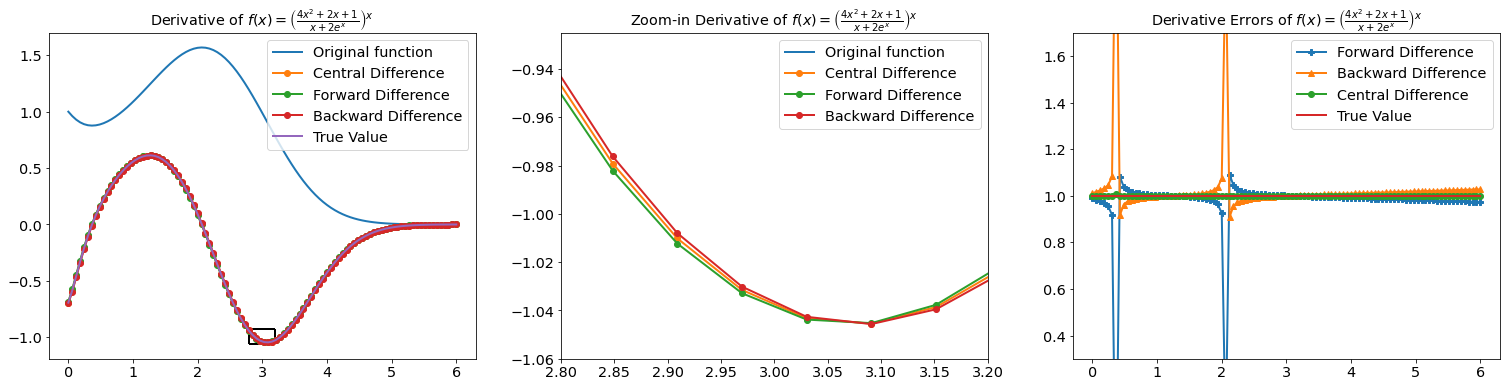

In [11]:
x2 = np.linspace(0,6,100)
f2 = lambda x: ((4*x**2 + 2*x + 1)/(x + 2*np.exp(x)))**x
y2 = f2(x2)
dydx2 = derivative_0(f2,x2)
dydx_b2 = derivative_0(f2,x2,method='backward')
dydx_f2 = derivative_0(f2,x2,method='forward')
dYdx2 = ((4*x2**2+2*x2+1)/(x2+2*np.exp(x2)))**x2*(np.log((4*x2**2+2*x2+1)/(x2+2*np.exp(x2)))+x2*((8*x2+2)/(x2+2*np.exp(x2))-(4*x2**2+2*x2+1)*(1+2*np.exp(x2))/(x2+2*np.exp(x2))**2)*(x2+2*np.exp(x2))/(4*x2**2+2*x2+1))
plt.figure(figsize=(26,6))
plt.subplot(131)
plt.plot(x2,f2(x2),label="Original function")
plt.plot(x2,dydx2,'o-',label='Central Difference')
plt.plot(x2,dydx_f2,'o-',label='Forward Difference')
plt.plot(x2,dydx_b2,'o-',label='Backward Difference')
plt.plot(x2,dYdx2,label='True Value')
plt.title(r'Derivative of $f(x)=\left(\frac{4x^2+2x+1}{x+2e^x}\right)^x$')
plt.legend(loc='best')
plt.hlines(-1.06,2.8,3.2,linestyles='-',color='k')
plt.hlines(-0.925,2.8,3.2,linestyles='-',color='k')
plt.vlines(2.8,-1.06,-0.925,linestyles='-',color='k')
plt.vlines(3.2,-1.06,-0.925,linestyles='-',color='k')
#plt.ylim(-15,15)
#plt.xlim(-2,4)
plt.subplot(132)
plt.plot(x2,f2(x2),label="Original function")
plt.plot(x2,dydx2,'o-',label='Central Difference')
plt.plot(x2,dydx_f2,'o-',label='Forward Difference')
plt.plot(x2,dydx_b2,'o-',label='Backward Difference')
#plt.plot(x1,dYdx,label='True Value')
plt.title(r'Zoom-in Derivative of $f(x)=\left(\frac{4x^2+2x+1}{x+2e^x}\right)^x$')
plt.legend(loc='best')
plt.ylim(-1.06,-0.925)
plt.xlim(2.8,3.2)
plt.subplot(133)
plt.plot(x2,dydx_f2/dYdx2,'P-',label='Forward Difference')
plt.plot(x2,dydx_b2/dYdx2,'^-',label='Backward Difference')
plt.plot(x2,dydx2/dYdx2,'o-',label='Central Difference')
plt.plot(x2,dYdx2/dYdx2,label='True Value')
plt.title(r'Derivative Errors of $f(x)=\left(\frac{4x^2+2x+1}{x+2e^x}\right)^x$')
plt.legend(loc='best')
plt.ylim(0.3,1.7)
#plt.xlim(-2,4)
plt.show()

### Otras opciones

- `scipy.misc.derivative`: La función de SciPy `scipy.misc.derivative` calcula las derivadas utilizando la fórmula de la diferencia central.
- `numpy.gradient`: El gradiente se calcula utilizando diferencias centrales precisas de segundo orden en los puntos interiores y diferencias de un solo lado precisas de primer o segundo orden (hacia delante o hacia atrás) en los límites. El gradiente devuelto tiene, por tanto, la misma forma que la matriz de entrada.

In [12]:
from scipy.misc import derivative

x = np.arange(0,5)
derivative(np.exp,x,dx=0.1)

array([ 1.0016675 ,  2.72281456,  7.40137735, 20.11902956, 54.68919246])

De esta manera entonces además es muy sencillo definir y calcular las derivadas de orden superior. ¿Qué pasa con la segunda, tercera, etc., derivadas? Pues muy sencillo con la función `scipy.misc.derivative` es muy fácil hallarlas. De hecho, si miramos la documentación de `scipy.misc.derivative` veremos que hay un argumento:

| | Parameters | |
| --- | --- | ---|
| func | function | Input function |
| x0 | float | The point at which the nth derivative is found. | 
| dx | float, optional | Spacing. | 
| n | int, optional | Order of the derivative. Default is 1. | 
| order | int, optional | Number of points to use, must be odd. | 

Por ejemplo:

In [13]:
x = np.arange(0,50)
f=lambda x: x*np.exp(x)
f1=derivative(lambda x: x*np.exp(x),x,dx=0.1,order = 31,n=1)
f2=derivative(lambda x: x*np.exp(x),x,dx=0.1,order = 31,n=2)
f3=derivative(lambda x: x*np.exp(x),x,dx=0.1,order = 31,n=3)

In [14]:
f1

array([1.00000000e+00, 5.43656366e+00, 2.21671683e+01, 8.03421477e+01,
       2.72990750e+02, 8.90478955e+02, 2.82400155e+03, 8.77306527e+03,
       2.68286219e+04, 8.10308393e+04, 2.42291124e+05, 7.18489701e+05,
       2.11581229e+06, 6.19378749e+06, 1.80390643e+07, 5.23042780e+07,
       1.51063879e+08, 4.34789150e+08, 1.24753941e+09, 3.56964602e+09,
       1.01884691e+10, 2.90139462e+10, 8.24529955e+10, 2.33875283e+11,
       6.62228053e+11, 1.87212738e+12, 5.28469945e+12, 1.48973507e+13,
       4.19414549e+13, 1.17940029e+14, 3.31280712e+14, 9.29563189e+14,
       2.60577769e+15, 7.29788171e+15, 2.04211610e+16, 5.70964843e+16,
       1.59515567e+17, 4.45327410e+17, 1.24238134e+18, 3.46373602e+18,
       9.65079594e+18, 2.68734267e+19, 7.47888225e+19, 2.08024937e+20,
       5.78322005e+20, 1.60697647e+21, 4.46317613e+21, 1.23903019e+22,
       3.43820060e+22, 9.53673286e+22])

In [15]:
f2

array([2.00000000e+00, 8.15484549e+00, 2.95562244e+01, 1.00427685e+02,
       3.27588900e+02, 1.03889211e+03, 3.22743035e+03, 9.86969843e+03,
       2.98095799e+04, 8.91339232e+04, 2.64317590e+05, 7.78363842e+05,
       2.27856708e+06, 6.63620088e+06, 1.92416685e+07, 5.55732953e+07,
       1.59949989e+08, 4.58944102e+08, 1.31319938e+09, 3.74812832e+09,
       1.06736343e+10, 3.03327619e+10, 8.60379083e+10, 2.43620086e+11,
       6.88717175e+11, 1.94413228e+12, 5.48042906e+12, 1.54293990e+13,
       4.33877119e+13, 1.21871363e+14, 3.41967187e+14, 9.58612039e+14,
       2.68474065e+15, 7.51252529e+15, 2.10046227e+16, 5.86824977e+16,
       1.63826799e+17, 4.57046553e+17, 1.27423727e+18, 3.55032942e+18,
       9.88618121e+18, 2.75132702e+19, 7.65280974e+19, 2.12752776e+20,
       5.91173605e+20, 1.64191074e+21, 4.55813732e+21, 1.26484331e+22,
       3.50836796e+22, 9.72746752e+22])

In [16]:
f3

array([3.00000000e+00, 1.08731273e+01, 3.69452805e+01, 1.20513222e+02,
       3.82187050e+02, 1.18730527e+03, 3.63085914e+03, 1.09663316e+04,
       3.27905379e+04, 9.72370071e+04, 2.86344055e+05, 8.38237984e+05,
       2.44132187e+06, 7.07861427e+06, 2.04442728e+07, 5.88423127e+07,
       1.68836100e+08, 4.83099055e+08, 1.37885935e+09, 3.92661062e+09,
       1.11587995e+10, 3.16515776e+10, 8.96228212e+10, 2.53364890e+11,
       7.15206297e+11, 2.01613718e+12, 5.67615867e+12, 1.59614472e+13,
       4.48339690e+13, 1.25802698e+14, 3.52653661e+14, 9.87660889e+14,
       2.76370361e+15, 7.72716887e+15, 2.15880845e+16, 6.02685112e+16,
       1.68138030e+17, 4.68765695e+17, 1.30609320e+18, 3.63692282e+18,
       1.01215665e+19, 2.81531137e+19, 7.82673724e+19, 2.17480616e+20,
       6.04025205e+20, 1.67684501e+21, 4.65309852e+21, 1.29065644e+22,
       3.57853532e+22, 9.91820218e+22])

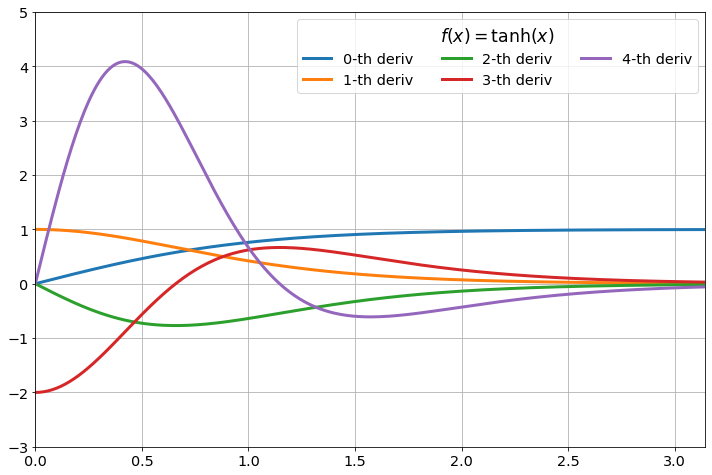

In [17]:
plt.figure(figsize=(12,8))
for i in range(5):
    x=np.arange(0,2*np.pi,0.01)
    f=lambda x: np.tanh(x)
    plt.plot(x,derivative(lambda x: np.tanh(x),x,dx=0.1,order = 51,n=i),linewidth=3,label=r"{}-th deriv".format(i))
    plt.legend(title=r"$f(x)=\tanh(x)$",ncol=3)
    plt.axis([0,np.pi,-3,5])
plt.grid()
plt.show()

## Diferenciación numérica con ruido

Como ya se ha dicho, a veces $f$ se da como un vector en el que $f$ es el valor de la función correspondiente para valores de datos independientes en otro vector $x$, que está cuadriculado. A veces, los datos pueden estar contaminados con ruido, lo que significa que su valor se desvía en una pequeña cantidad de lo que sería si se calculara a partir de una función matemática pura. Esto puede ocurrir a menudo en la ingeniería debido a inexactitudes en los dispositivos de medición o los propios datos pueden ser ligeramente modificados por perturbaciones fuera del sistema de interés. Por ejemplo, puedes estar intentando escuchar a tu amigo hablar en una habitación llena de gente. La señal $f$ podría ser la intensidad y los valores tonales del discurso de su amigo. Sin embargo, como la sala está abarrotada, el ruido de otras conversaciones se escucha junto con el discurso de su amigo, y resulta difícil entenderlo.

Para ilustrar este punto, calculamos numéricamente la derivada de una simple onda coseno corrompida por una pequeña onda seno. Consideremos las dos funciones siguientes:

\begin{equation}
f(x)=\cos(x)
\end{equation}
y
\begin{equation}
f_{\epsilon,\omega}(x)=\cos(x)+\epsilon\sin(\omega x)
\end{equation}

donde $0<\epsilon<<1$ es un número muy pequeño y $\omega$ es un número grande. Cuando $\epsilon$ es pequeño, está claro que $f\approx f_{\epsilon,\omega}$. Para ilustrar este punto, trazamos $f_{\epsilon,\omega}(x)$ para $\epsilon=0.01$ y $\omega=100$, y podemos ver que está muy cerca de $f(x)$, como se muestra en la siguiente figura.

Las derivadas de estas dos dunciones son:
\begin{equation}
f'(x)=-\sin(x), \ \ \ \ f'_{\epsilon,\omega}(x)=-\sin(x)+\epsilon\omega\cos(\omega x)
\end{equation}


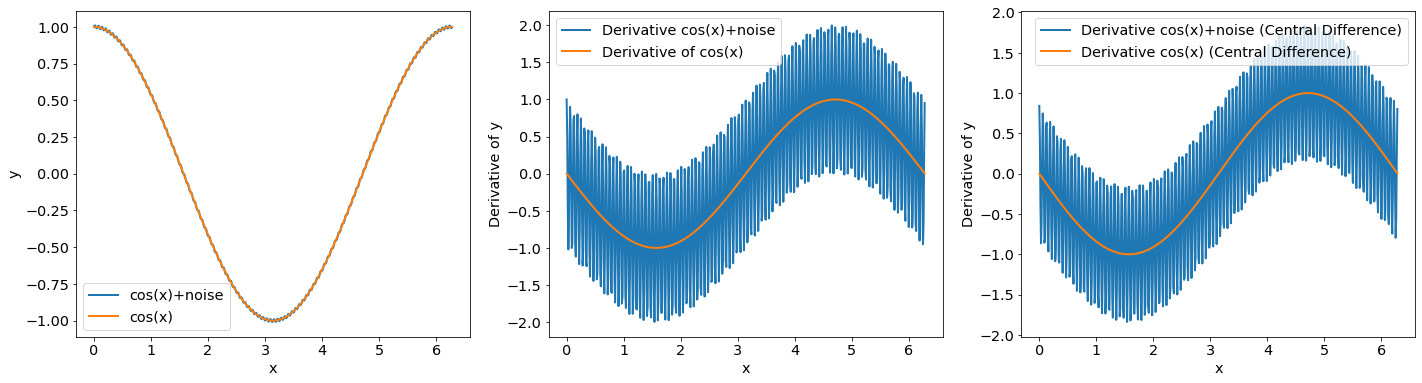

In [18]:
x = np.arange(0, 2*np.pi, 0.01) 
# compute function
omega = 100
epsilon = 0.01
y = np.cos(x) 
y_noise = y + epsilon*np.sin(omega*x)
yp = -np.sin(x) 
y_noisep = yp + epsilon*omega*np.cos(omega*x)
# Plot solution
plt.figure(figsize=(24,6))
plt.subplot(131)
plt.plot(x,y_noise,label='cos(x)+noise')
plt.plot(x,y,label='cos(x)')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
# Plot solution
plt.subplot(132)
plt.plot(x,y_noisep,label='Derivative cos(x)+noise')
plt.plot(x,yp,label='Derivative of cos(x)')
plt.xlabel('x')
plt.ylabel('Derivative of y')
plt.legend()
plt.subplot(133)
g2=derivative(lambda x: np.cos(x)+epsilon*np.sin(omega*x),x,dx=0.01)
plt.plot(x,g2,label='Derivative cos(x)+noise (Central Difference)')
g1=derivative(lambda x: np.cos(x),x,dx=0.01)
plt.plot(x,g1,label='Derivative cos(x) (Central Difference)')
plt.xlabel('x')
plt.ylabel('Derivative of y')
plt.legend()
plt.show()

## Volviendo a nuestro problema inicial de estimar la tasa de cambio de anomalía de temperatura global

Estimemos entonces

In [19]:
temp_data.head()

,Year,No_Smoothing,Lowess(5)
0,1880,-0.16,-0.09
1,1881,-0.08,-0.12
2,1882,-0.10,-0.16
3,1883,-0.17,-0.20
4,1884,-0.28,-0.23


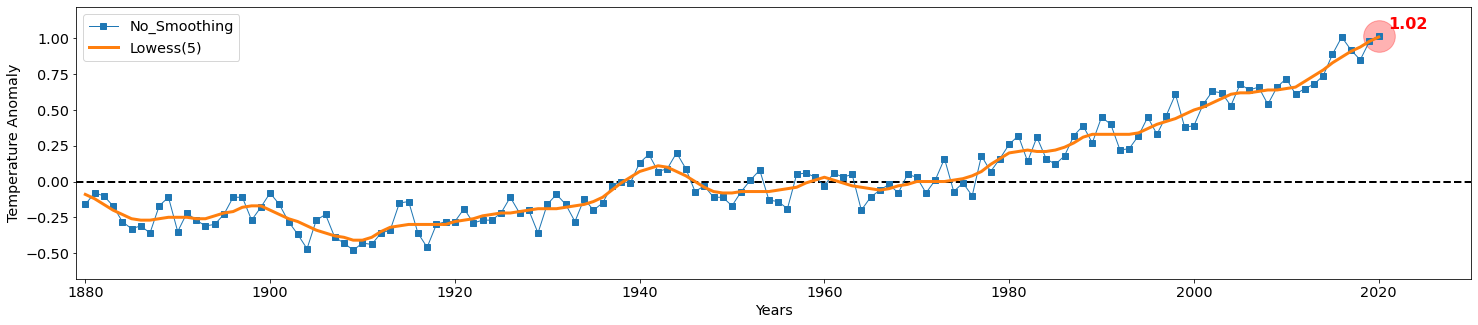

In [20]:
plt.figure(figsize=(25,5))
plt.plot(temp_data["Year"],temp_data["No_Smoothing"],marker="s",linewidth=1,label="No_Smoothing")
plt.plot(temp_data["Year"],temp_data["Lowess(5)"],linewidth=3,label="Lowess(5)")
plt.xlabel("Years")
plt.ylabel("Temperature Anomaly")
plt.text(temp_data["Year"].iloc[-1]+1,temp_data["No_Smoothing"].iloc[-1]+0.05,str(temp_data["No_Smoothing"].iloc[-1]),fontsize=16,color="red",weight="bold")
plt.axis([temp_data["Year"].min()-1,temp_data["Year"].max()+10,temp_data["No_Smoothing"].min()-0.2,temp_data["No_Smoothing"].max()+0.2])
plt.scatter(temp_data["Year"].iloc[-1],temp_data["No_Smoothing"].iloc[-1],s=1000,alpha=0.3,color="red")
plt.hlines(0,temp_data["Year"].min()-1,temp_data["Year"].max()+10,linestyles='--',color="k")
plt.legend()
plt.show()

In [21]:
dy = np.gradient(temp_data["No_Smoothing"])
dx = np.gradient(temp_data["Year"])
d = dy/dx
d2=np.gradient(temp_data["No_Smoothing"],temp_data["Year"])
d3=np.gradient(temp_data["Lowess(5)"],temp_data["Year"])

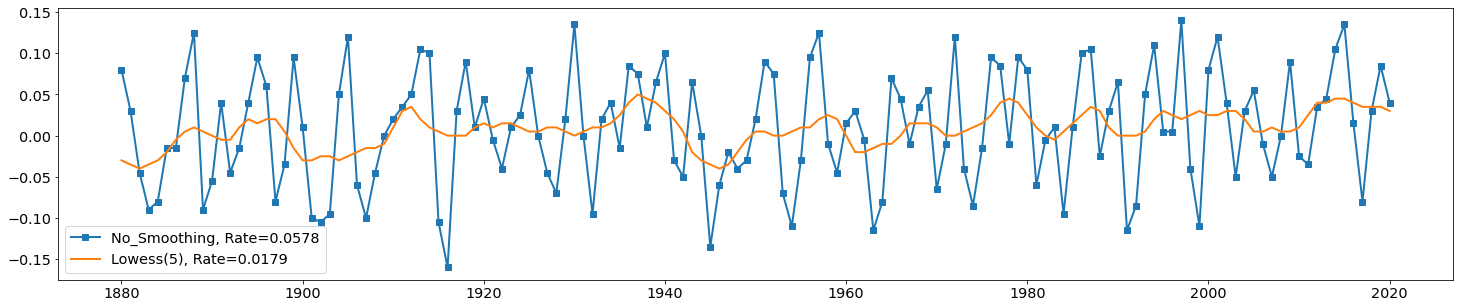

In [22]:
plt.figure(figsize=(25,5))
plt.plot(temp_data["Year"],d2,marker="s",label="No_Smoothing, Rate={}".format(round(np.mean(abs(d2)),4)))
plt.plot(temp_data["Year"],d3,label="Lowess(5), Rate={}".format(round(np.mean(abs(d3)),4)))
plt.legend()
plt.show()

In [23]:
jj=temp_data["Year"]>=1980
temp_data2=temp_data[jj]
dy2 = np.gradient(temp_data2["No_Smoothing"])
dx2 = np.gradient(temp_data2["Year"])
d2 = dy2/dx2
d22=np.gradient(temp_data2["No_Smoothing"],temp_data2["Year"])
d32=np.gradient(temp_data2["Lowess(5)"],temp_data2["Year"])

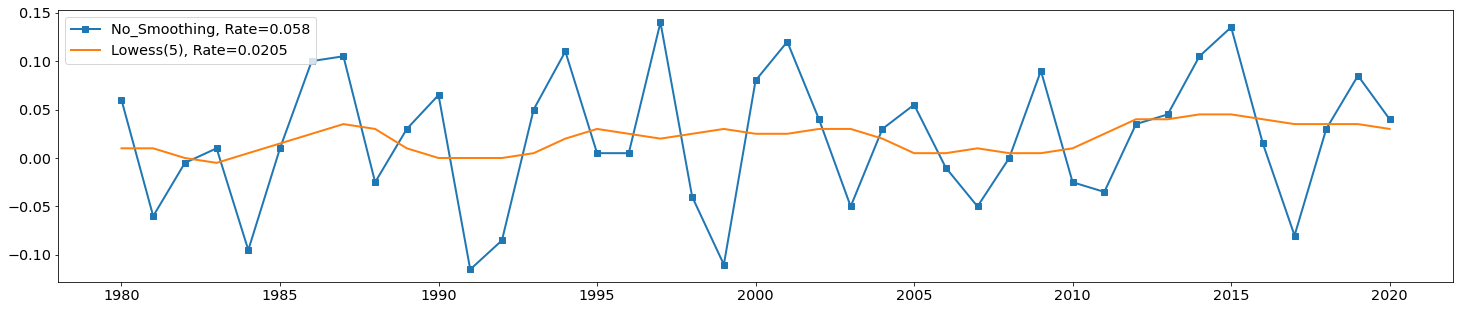

In [24]:
plt.figure(figsize=(25,5))
plt.plot(temp_data2["Year"],d22,marker="s",label="No_Smoothing, Rate={}".format(round(np.mean(abs(d22)),4)))
plt.plot(temp_data2["Year"],d32,label="Lowess(5), Rate={}".format(round(np.mean(abs(d32)),4)))
plt.legend()
plt.show()

In [25]:
import statsmodels.api as sm
X = temp_data2["Year"]
y = temp_data2["Lowess(5)"]
X = sm.add_constant(X)
#Fit and summary:
model = sm.OLS(y, X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Lowess(5)   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.965
Method:                 Least Squares   F-statistic:                     1107.
Date:                Tue, 28 Sep 2021   Prob (F-statistic):           3.03e-30
Time:                        17:41:29   Log-Likelihood:                 70.346
No. Observations:                  41   AIC:                            -136.7
Df Residuals:                      39   BIC:                            -133.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -38.6721      1.178    -32.835      0.000     -41.054     -36.290
Year           0.0196      0.001     33.274      0.000       0.018       0.021
==============================================================================
Omnibus:                        2.616   Durbin-Watson:                   0.120
Prob(Omnibus):                  0.270   Jarque-Bera (JB):                2.451
Skew:                           0.553   Prob(JB):                        0.294
Kurtosis:                       2.541   Cond. No.                     3.38e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.38e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

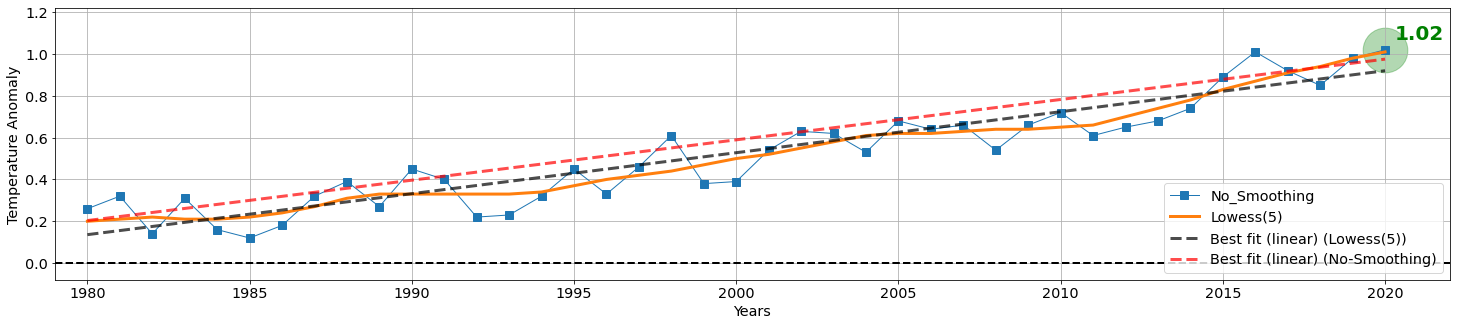

In [26]:
plt.figure(figsize=(25,5))
plt.plot(temp_data2["Year"],temp_data2["No_Smoothing"],marker="s",markersize=8,linewidth=1,label="No_Smoothing")
plt.plot(temp_data2["Year"],temp_data2["Lowess(5)"],linewidth=3,label="Lowess(5)")
plt.xlabel("Years")
plt.ylabel("Temperature Anomaly")
plt.text(temp_data2["Year"].iloc[-1]+0.3,temp_data2["No_Smoothing"].iloc[-1]+0.05,str(temp_data2["No_Smoothing"].iloc[-1]),fontsize=20,color="green",weight="bold")
plt.axis([temp_data2["Year"].min()-1,temp_data2["Year"].max()+2,temp_data2["No_Smoothing"].min()-0.2,temp_data2["No_Smoothing"].max()+0.2])
plt.scatter(temp_data2["Year"].iloc[-1],temp_data2["No_Smoothing"].iloc[-1],s=2000,alpha=0.3,color="green")
plt.hlines(0,temp_data2["Year"].min()-1,temp_data2["Year"].max()+10,linestyles='--',color="k")
plt.plot(temp_data2["Year"],0.0196*temp_data2["Year"]-38.6721,color='k',linestyle="--",alpha=0.7,linewidth=3,label="Best fit (linear) (Lowess(5))")
plt.plot(temp_data2["Year"],0.0193*temp_data2["Year"]-38.0106,color='r',linestyle="--",alpha=0.7,linewidth=3,label="Best fit (linear) (No-Smoothing)")
plt.legend(loc=4)
plt.grid()
plt.show()

**Resumen**:
- Dado que la derivación explícita de las funciones es a veces engorrosa para las aplicaciones de ingeniería, pueden ser preferibles las aproximaciones numéricas. 
- La aproximación numérica de las derivadas puede realizarse utilizando una malla en la que la derivada se aproxima mediante diferencias finitas. 
- Las diferencias finitas aproximan la derivada mediante cocientes de diferencias en el valor de la función en intervalos pequeños.
- Los esquemas de diferencias finitas tienen diferentes órdenes de aproximación dependiendo del método utilizado.
- Hay problemas con las diferencias finitas para la aproximación de las derivadas cuando los datos son ruidosos.

# Tarea

Para analizar algunas cosas.

- **Tarea 1:** La serie de Taylor de una función es una suma infinita de términos que se expresan en términos de las derivadas de la función en un único punto. Para la mayoría de las funciones comunes, la función y la suma de su serie de Taylor son iguales cerca de este punto. Las series de Taylor reciben su nombre de Brook Taylor, que las introdujo en 1715. La suma parcial formada por los primeros $n + 1$ términos de una serie de Taylor es un polinomio de grado $n$ que se denomina n-ésimo polinomio de Taylor de la función. Los polinomios de Taylor son aproximaciones de una función, que se vuelven generalmente mejores a medida que aumenta $n$. El teorema de Taylor proporciona estimaciones cuantitativas sobre el error introducido por el uso de tales aproximaciones. Si la serie de Taylor de una función es convergente, su suma es el límite de la secuencia infinita de los polinomios de Taylor. Una función puede diferir de la suma de su serie de Taylor, incluso si su serie de Taylor es convergente. Una función es analítica en un punto $x$ si es igual a la suma de sus series de Taylor en algún intervalo abierto (o disco abierto en el plano complejo) que contenga a $x$. Esto implica que la función es analítica en cada punto del intervalo (o disco). 

    La serie de Taylor de una función de valor real o complejo $f(x)$ que es infinitamente diferenciable en un número real o complejo a es la serie de potencias
    \begin{equation}
    f(a)+\frac{f'(a)}{1!}(x-a)+\frac{f''(a)}{2!}(x-a)^2+\frac{f''(a)}{3!}(x-a)^3++\frac{f''(a)}{4!}(x-a)^4+...
    \end{equation}
    donde $n!$ denota el factorial de $n$. En la notación sigma más compacta, esto se puede escribir como
    \begin{equation}
    f(x)=\sum_{n=0}^{\infty}a_n(x-b)^n=\sum_{n=0}^{\infty}\frac{f^{(n)}(b)}{n!}(x-b)^n
    \end{equation}
    donde $f^{(n)}(b)$ denota la enésima derivada de $f$ evaluada en el punto $b$. (La derivada de orden cero de $f$ se define como la propia $f$ y $(x - b)^0$ y $0!$ se definen como 1). 

    Use esto anterior para aproximar la función 
    \begin{equation}
    f(x)=\frac{xe^x}{x^2+3x+1}
    \end{equation}
    en el intervalo $[-5,5]$. Calcule varias aproximaciones y establezca un límite de la serie de taylor para obtener una aproximación ajustada y precisa.

In [34]:
f = lambda x: x*np.e**x/(x**2+3*x+1)
x = np.linspace(-5,5,100)
y = f(x)
dydx = np.gradient(y)
dydx

array([-4.81617313e-04, -5.23668871e-04, -6.16187229e-04, -7.27526428e-04,
       -8.62236355e-04, -1.02620394e-03, -1.22713514e-03, -1.47524957e-03,
       -1.78430174e-03, -2.17311653e-03, -2.66795692e-03, -3.30628236e-03,
       -4.14291605e-03, -5.26056487e-03, -6.78860179e-03, -8.93848543e-03,
       -1.20751700e-02, -1.68736596e-02, -2.47016321e-02, -3.87037030e-02,
       -6.76183476e-02, -1.45100799e-01, -5.58778143e-01,  1.28232233e+00,
        1.03041296e+00, -8.29515006e-01, -1.68052406e-01, -7.22234923e-02,
       -3.80778180e-02, -2.14795208e-02, -1.18183306e-02, -5.40573459e-03,
       -6.50796833e-04,  3.25293931e-03,  6.78362354e-03,  1.02840991e-02,
        1.40662390e-02,  1.84947016e-02,  2.40959113e-02,  3.17604844e-02,
        4.32086165e-02,  6.22636529e-02,  9.91664664e-02,  1.91039673e-01,
        6.02597772e-01, -2.37314642e+00, -1.23903576e+00,  1.81345187e+00,
        2.92127022e-01,  1.37555892e-01,  8.78736094e-02,  6.62237917e-02,
        5.55163277e-02,  

***SOLAR SUNSPOT NUMBER:***

In [28]:
#Description of dataset in: https://wwwbis.sidc.be/silso/infosnytot
# Data available on: https://wwwbis.sidc.be/silso/datafiles
SSN=pd.read_csv("../datas/SN_y_tot_V2.0.csv",delimiter=";",names=["Year","mean","std","observations","provisional"])
SSN.tail()

,Year,mean,std,observations,provisional
316,2016.5,39.8,3.9,9940,1
317,2017.5,21.7,2.5,11444,1
318,2018.5,7.0,1.1,12611,1
319,2019.5,3.6,0.5,12884,1
320,2020.5,8.8,4.1,14440,1


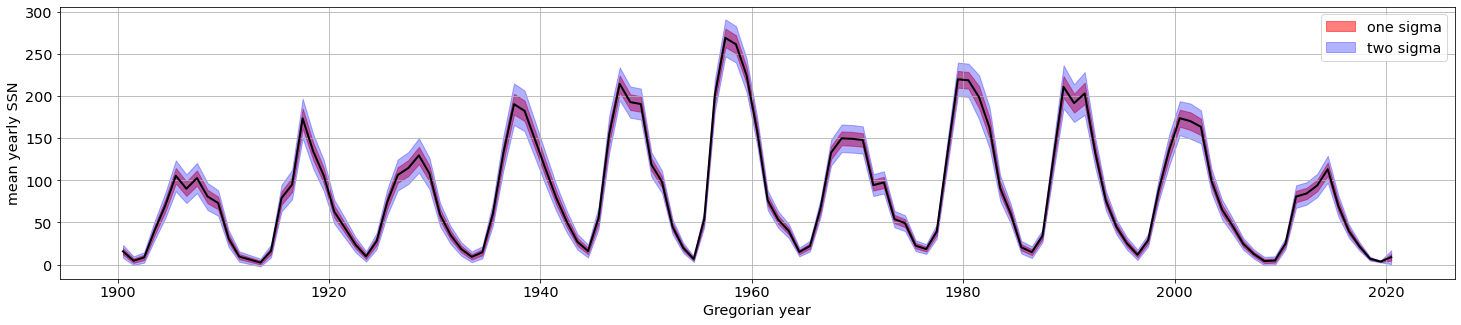

In [29]:
plt.figure(figsize=(25,5))
ii=SSN["Year"]>=1900
SSN2=SSN[ii]
plt.plot(SSN2["Year"],SSN2["mean"],color='k')
plt.fill_between(SSN2["Year"],SSN2["mean"]-SSN2["std"],SSN2["mean"]+SSN2["std"],color="red",alpha=0.5,label="one sigma")
plt.fill_between(SSN2["Year"],SSN2["mean"]-2*SSN2["std"],SSN2["mean"]+2*SSN2["std"],color="blue",alpha=0.3,label="two sigma")
plt.xlabel("Gregorian year")
plt.ylabel("mean yearly SSN")
plt.legend()
plt.grid()
plt.show()

- **Tarea 2**: Vamos a probar algo. Quisiera ver si es posible modelar esta serie temporal a través de una expansión ortogonal polinomial. Así, dada una función continuua $f(x)$, entonces sabemos que 
    \begin{equation}
    f_n(x)=\sum_{\ell =0}^{n}a_{\ell}P_{\ell}(x)
    \end{equation}
    donde $f_n(x)$ converge a la media de $f(x)$ en $n\to \infty$, sabiendo que
    \begin{equation}
    a_{\ell }={\frac{2\ell +1}{2}}\int _{-1}^{1}f(x)P_{\ell }(x)dx
    \end{equation}
    Una expresión especialmente compacta para los polinomios de Legendre viene dada por la fórmula de Rodrigues: 
    \begin{equation}
    P_{n}(x)={\frac {1}{2^{n}n!}}{\frac {d^{n}}{dx^{n}}}(x^{2}-1)^{n}
    \end{equation}

    Entonces, nos gustaría saber si esta aproximación es buena para este problema de modelar los ciclos solares con alguna tolerancia. Los datos están en `datas/SN_y_tot_V2.0.csv`. Si esto sale bien, entonces es posible (quizás) bajo una cierta tolerancia y error (por su puesto) poder predecir los futuros sunspot.!!!

- **Tarea 3**: http://www.sc.ehu.es/sbweb/fisica3/fluidos/pelicula/pelicula.html. Haga un análisis numérico, usando sólo derivadas (e integrales) numéricas en la cual podamos modelar, el área de la película de jabón que se forma entre los extremos de dos aros de radio $r_1$ y $r_2$ separados una distancia $h$. Haga una rutina que permita ver los límites de este modelo. ¿Cuándo ya no se formará una película? ¿Bajo que condiciones?

- **Tarea 4**: Mire lapágina https://web.media.mit.edu/~crtaylor/calculator.html. Allí podrá encontrar un applet que le permite construir las formulas de $n$-puntos para la primera derivada y las derivadas de orden mayor. Haga un código construyendo una función `my_derivative(f,x,N,p)` que tome como argumento un número $N$ (orden de la derivada) y $p$ para designar se se usa una fórmula de $p$-puntos (con p<5). Incluya en esta función también el cálculo de la derivada de $f$ de dicho orden usando `scipy.misc.derivative` y compare los resultados con los errores correspondientes con el resultado analítico para un par de funciones no tan triviales.

- **Tarea 5**: ¡Esto pudiera (debería) funcionar! Tomemos la misma data de Solar Sunspot Number y intentemos modelar el comportamiento de estos sunspot numbers como una serie de Fourier, calculando los coeficientes de Fourier usando solo derivadas e integrales numéricas. Haga una función con un pequeño código que permita hacer esto sencillamente para un cierto orden de aproximación y hagamos una estimación del error para ese orden de aproximación. Si esto sale bien, entonces es posible (quizás) bajo una cierta tolerancia y error (por su puesto) poder predecir los futuros sunspot.!!!